### This notebook is to calculate the IAD of olinvine XES.

- Good reference1: `xes_int-v2`, containing the origianl iad and run number by Dan

- Good reference2: `xes-fp.ipynb`, a good manul for read and process `h5py` data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [311]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import h5py
import glob
from datetime import datetime
mpl.rcParams['pdf.fonttype'] = 42

In [314]:
n_smooth = 5
save_img = True
save_date = False
date = datetime.now()
date = date.strftime('%m%d%y')
print(date)


041924


## Define functions

In [3]:
def read_xes(filename):
    f = h5py.File(filename, "r")

    if len(f.keys())== 1:
        return None, None
    else:
        laserOff = f["off/spectrum_bkg_norm"]
        laserOn  = f["on/spectrum_bkg_norm"]
        return laserOff, laserOn

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    print(type(y))
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [46]:
def lin_bg_sub(spectrum):
    y_0 = spectrum[:11].mean()
    y_1 = spectrum[-11:].mean()
    x_n = len(spectrum)
    y_bg = (y_1 - y_0) / x_n * np.arange(x_n) + y_0
    return spectrum - y_bg

In [115]:
def get_norm_spectrum(spectrum):
        spect = (spectrum - spectrum.min()) # / (spectrum.max() - spectrum.min())
        norm_fac = spect.sum()
        return spect/norm_fac

In [5]:
## This function defined. by Xuehui
# This function is ued to deleted the noise which could be caused by the edges of the detector, like image titled test below
def remove_null(spect):
    idx_zero = np.where(spect ==0)[0]
    idx_new = np.append(idx_zero, [np.min(idx_zero)-1, np.max(idx_zero)+1])
    return np.delete(spect, idx_new)   

### process an example data

In [150]:
fn_xes = '../xes/spectrum-161.h5'

In [60]:
with h5py.File(fn_xes, 'r') as f:
    # Access the contents of the file
    dataset_names = list(f)
    print(dataset_names)
    
    # Check if the dataset 'off' exists in the file
    if 'off' in dataset_names:
        print("Dataset 'off' exists.")
        # Access the group corresponding to 'off'
        group_off = f['off']
        # List the contents of the group
        group_off_contents = list(group_off)
        print("Contents of 'off' group:", group_off_contents)
    else:
        print("Dataset 'off' does not exist in the file.")

['off', 'on']
Dataset 'off' exists.
Contents of 'off' group: ['events', 'image', 'roi', 'spectrum', 'spectrum_bkg', 'spectrum_bkg_norm']


In [87]:
f_t = h5py.File(fn_xes, "r")
im_ref = np.transpose(f_t['off/image'][:])
im = np.transpose(f_t['on/image'][:])

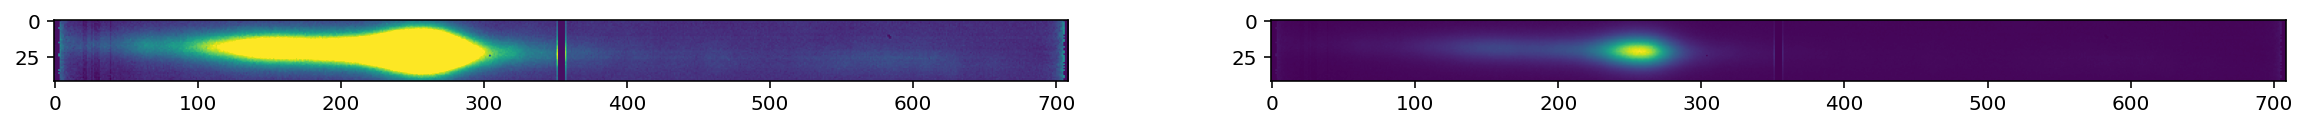

In [134]:
f, ax = plt.subplots(1, 2, figsize = (20, 10))
#ax[0,0].imshow(im); ax[0,1].imshow(im_ref)
ax[0].imshow(im[486:528, :], vmax = 200); ax[1].imshow(im[486:528, :])
#ax[0,0].hlines(500, 0, 700)
#ax[0,0].hlines(518, 0, 700)
#ax[0,1].hlines(500, 0, 700)
#ax[0,1].hlines(518, 0, 700)


In [152]:
im_rmbg = im[486:528, 10:685].sum(axis=0)- im[400:485, 10:685].sum(axis=0)

> I try to remove the background of spectrum, but failed.
>
> See detailed in the image below


(50.0, 360.0)

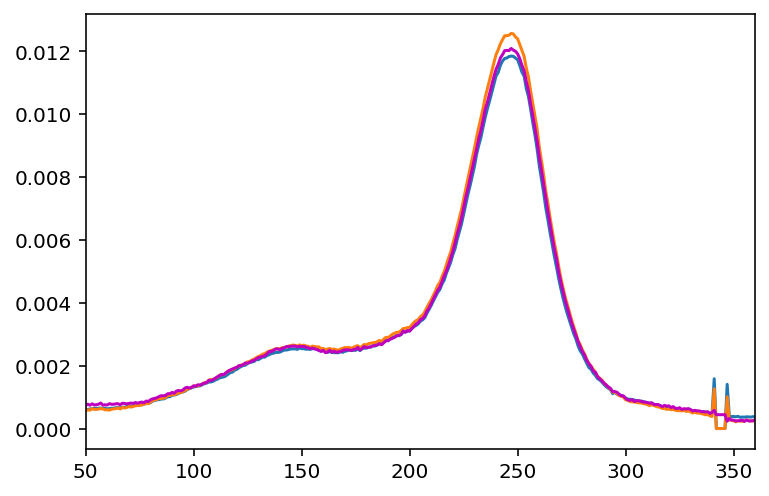

In [153]:
#plt.figure(dpi = 200)
plt.plot(get_norm_spectrum(im[499:515, 10:685].sum(axis=0)))
plt.plot(np.asarray(laserOn_ol))
plt.plot(get_norm_spectrum(im_rmbg), c = 'm')
plt.xlim(50, 360)

## Data Process

In [40]:
laserOff_ol, laserOn_ol = read_xes(fn_xes)

In [41]:
pix = np.arange(len(laserOff_ol))

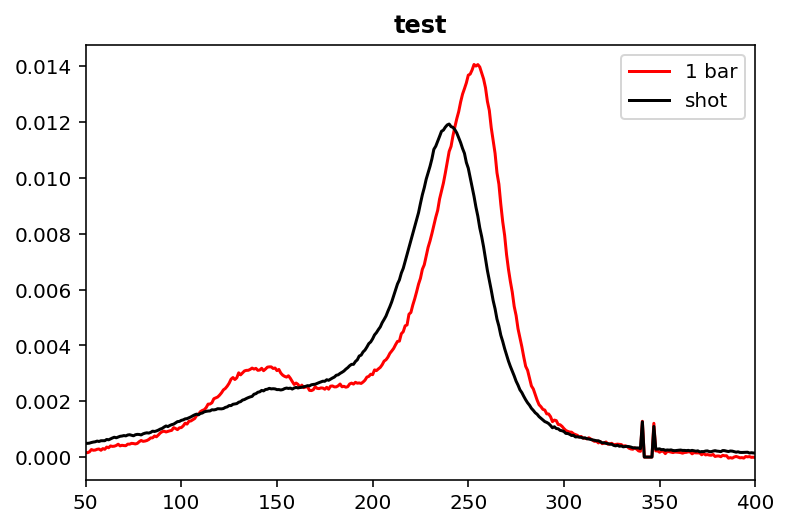

In [329]:
plt.plot(np.asarray(laserOff_ol), c= 'r', label = '1 bar')
plt.plot(np.asarray(laserOn_ol), c= 'k', label = 'shot')
plt.xlim(50, 400)
plt.title('test', fontweight = 'bold')
plt.legend()

- I improve the data quality by delete the null data 

Text(0.5, 1.0, 'improved')

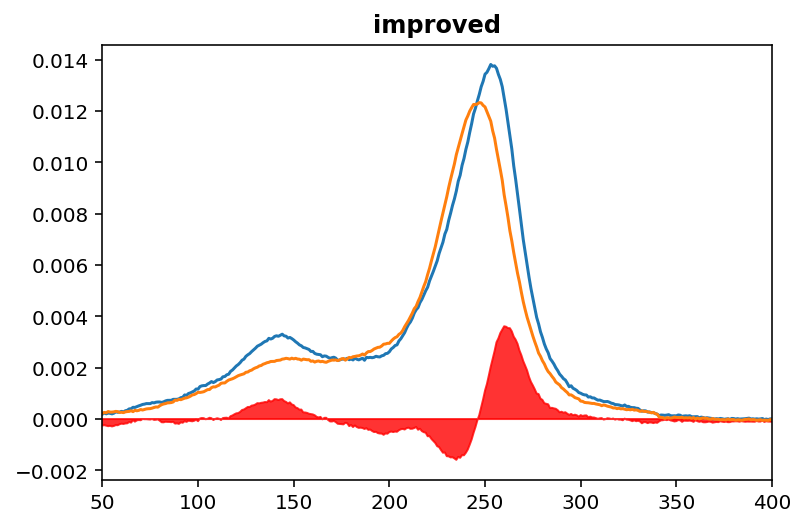

In [47]:
plt.plot(lin_bg_sub(remove_null(np.asarray(laserOff_ol))))
plt.plot(lin_bg_sub(remove_null(np.asarray(laserOn_ol))))
plt.fill_between(np.arange(len(remove_null(np.asarray(laserOn_ol)))), 0, 
                 remove_null(np.asarray(laserOff_ol))-remove_null(np.asarray(laserOn_ol)), color = 'red', alpha = 0.8)
plt.xlim(50, 400)
plt.title('improved', fontweight = 'bold')


> Below is the run_num in Dan's dataset

<img src="run_num.png" alt="Alt Text" width="300" height="200">

In [11]:
ol_ls = [174, 90, 161, 282, 85, 159, 84, 275, 285, 158, 158, 219, 172, 173]
fl= glob.glob('../xes/spectrum-*.h5')
fl_roi = []
for f in fl:
    if int(f.split('-')[1].split('.h')[0]) in ol_ls:
        fl_roi.append(f)

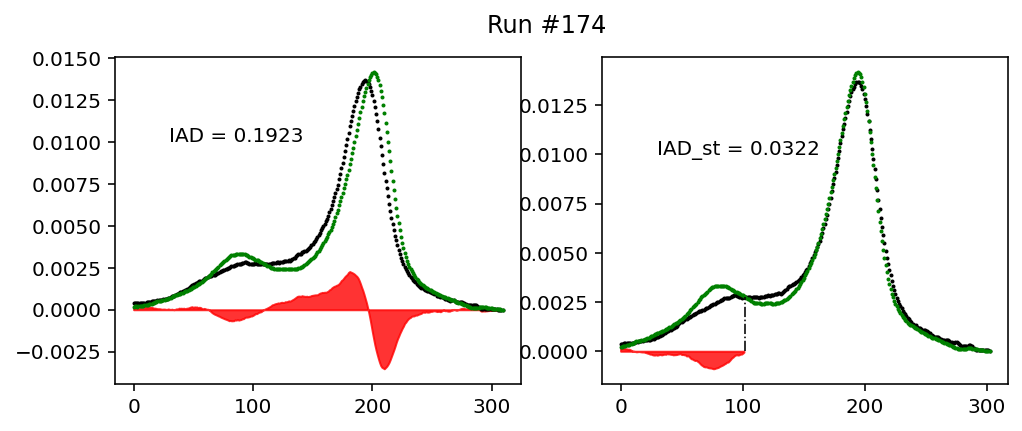

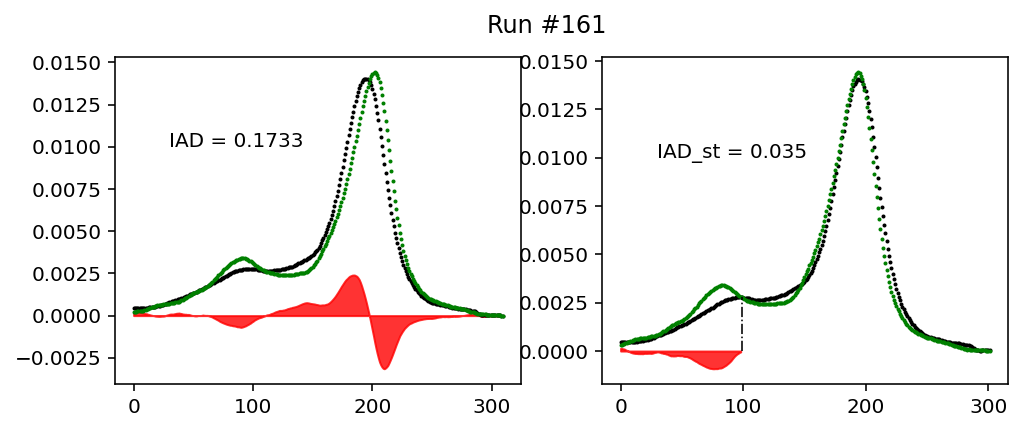

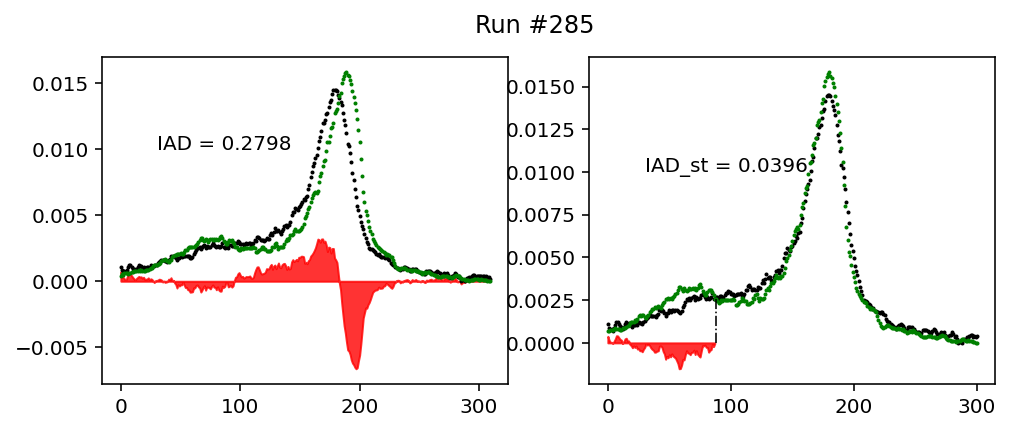

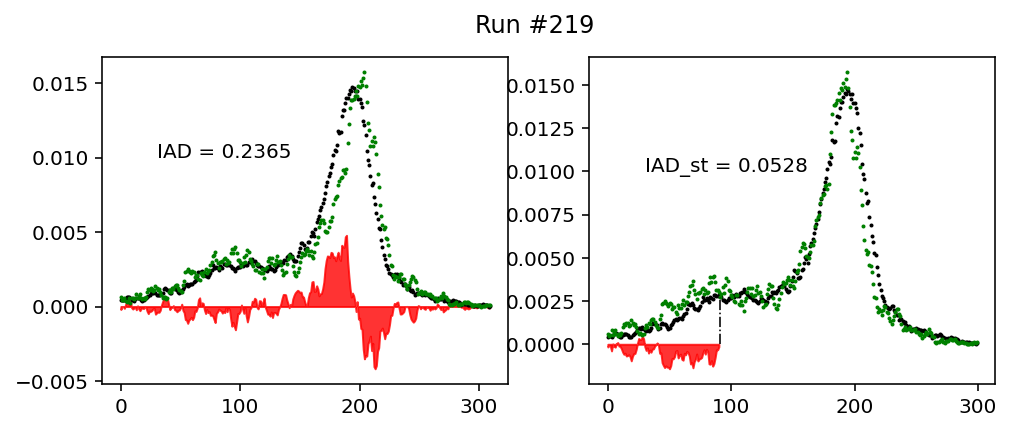

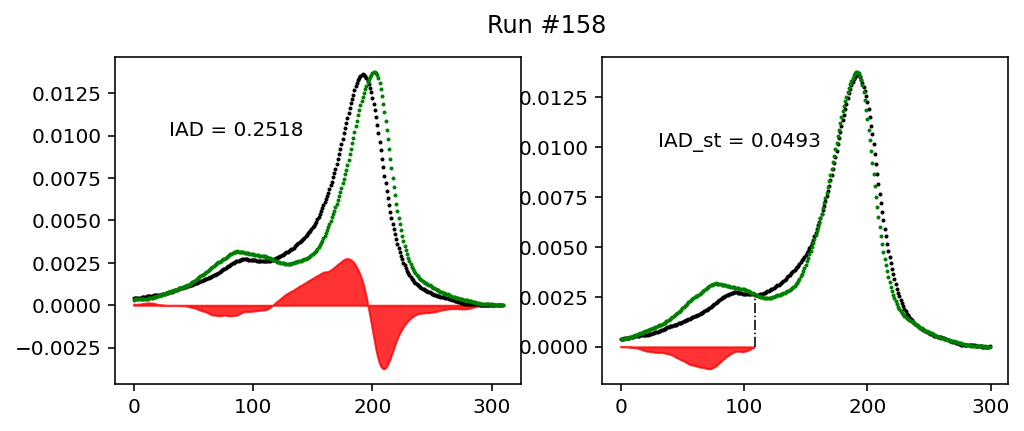

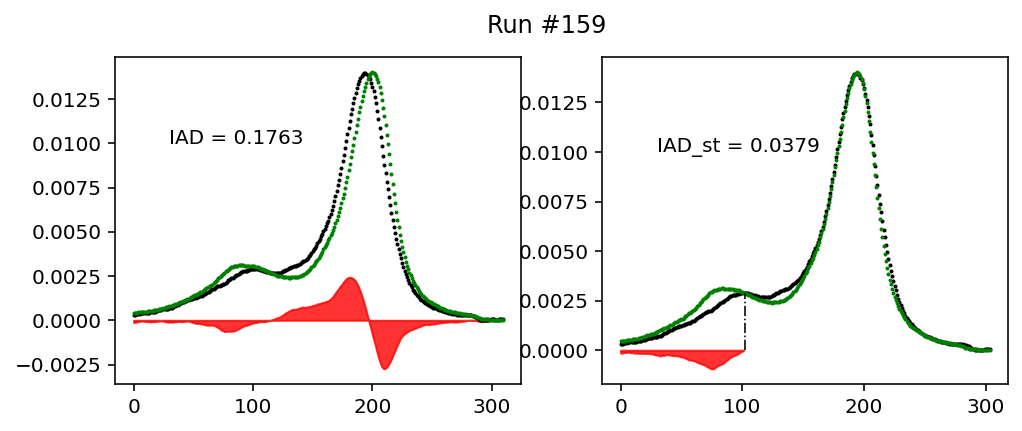

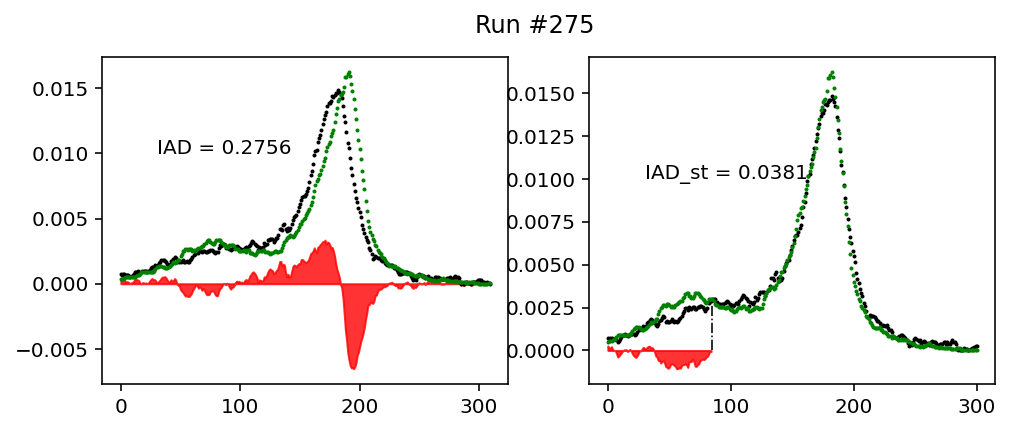

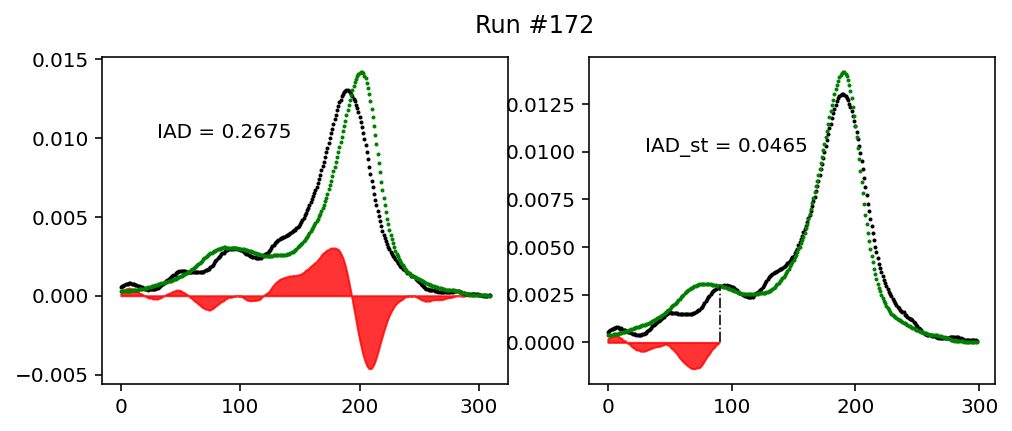

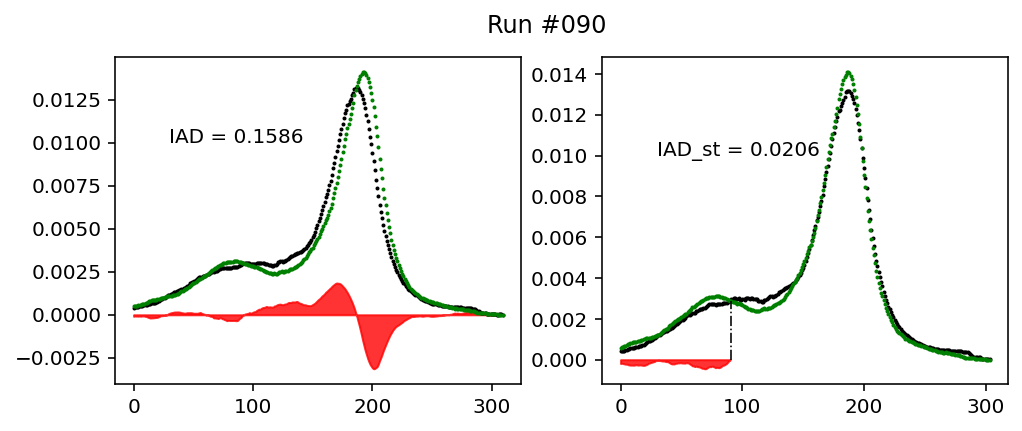

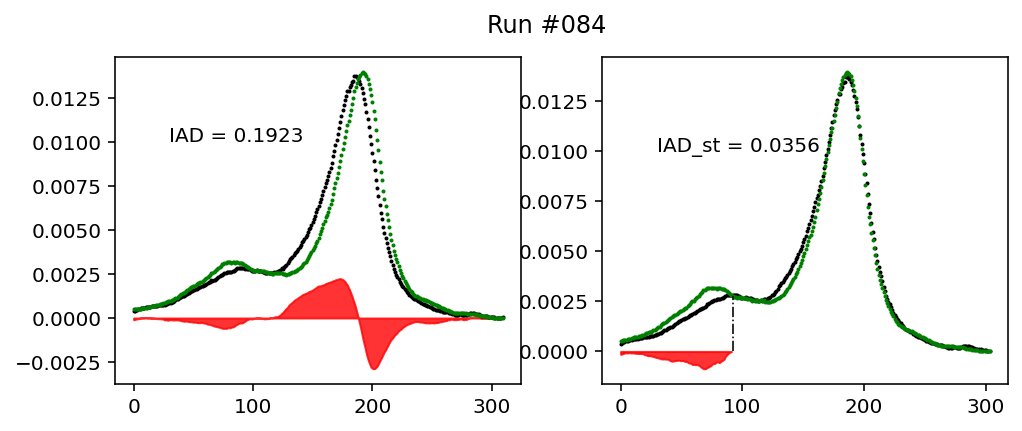

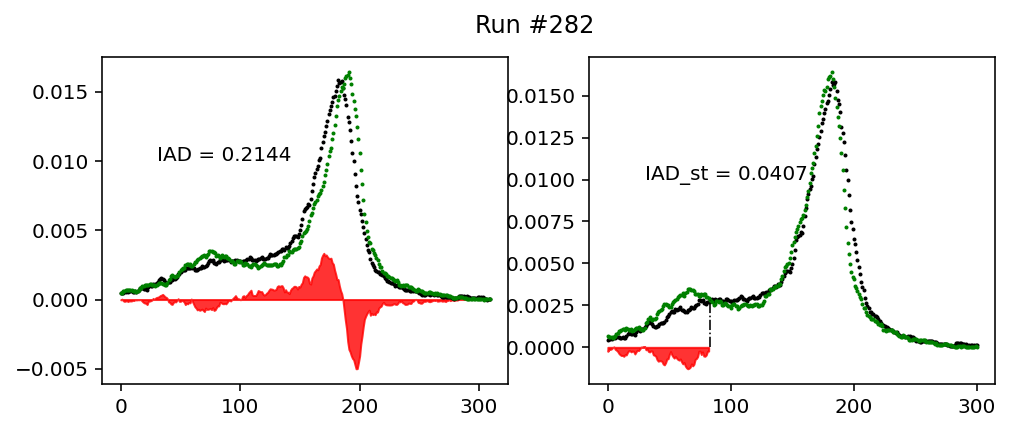

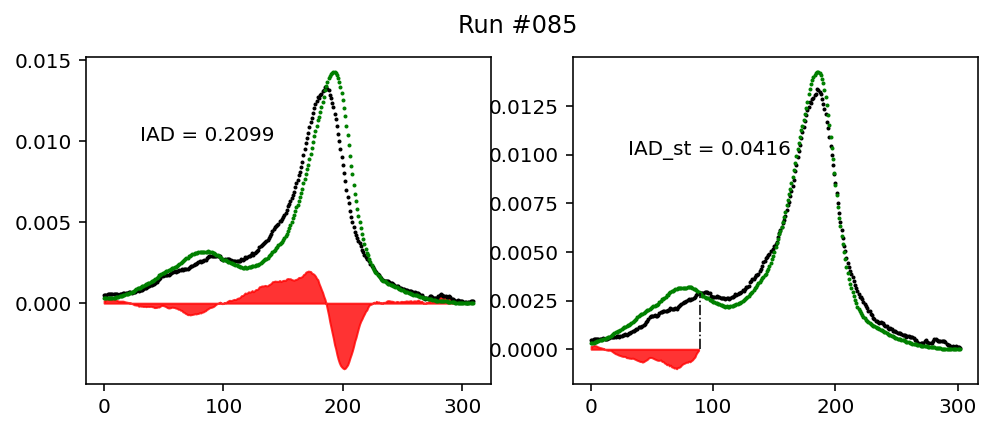

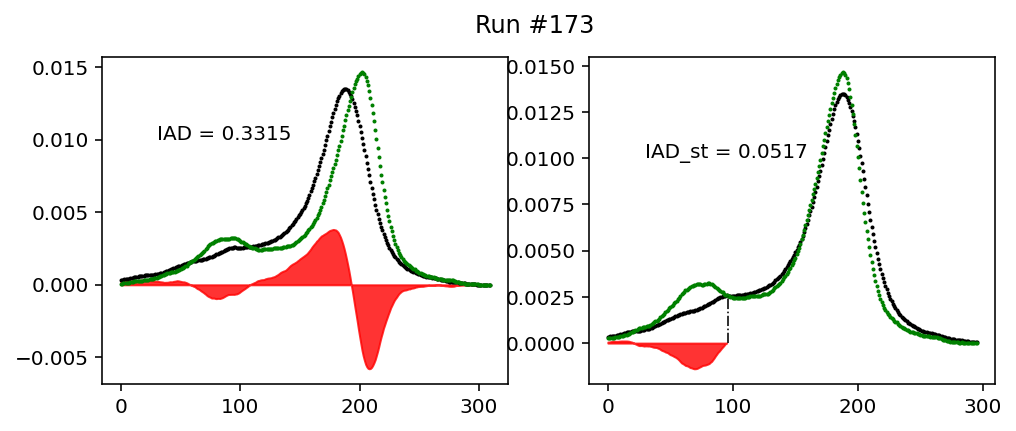

In [317]:
iad = []
for i in fl_roi:
    run_num = i.split('-')[1].split('.h')[0]
    laserOff_ol, laserOn_ol = read_xes(i)
    spect_ref = get_norm_spectrum(moving_average(remove_null(np.asarray(laserOff_ol)), n = n_smooth)[50:360])
    spect = get_norm_spectrum(moving_average(remove_null(np.asarray(laserOn_ol)), n=n_smooth)[50:360])
    i_max = spect.argmax()
    i_ref_max = spect_ref.argmax()
    i_dif =  i_ref_max - i_max
    if i_dif < 0:
        spec_align = spect[-i_dif:]
        spec_r_align = spect_ref[:i_dif]
    elif i_dif > 0:
        spec_align = spect[:-i_dif]
        spec_r_align = spect_ref[i_dif:]
    else:
        spec_align = spect
        spec_r_align = spect_ref
        
    transition_point = None
    for j in range(60, 120):
        if spec_align[j] <= spec_r_align[j] and spec_align[j + 1] > spec_r_align[j + 1]:
            transition_point = j + 1
            break
    if transition_point is None:
        transition_point = 100
    
    iad_kb = np.sum(np.abs(spect-spect_ref))
    iad_kb_st= np.sum(np.abs(spec_align[:transition_point]-spec_r_align[:transition_point]))
    iad.append([int(run_num), iad_kb, iad_kb_st])
        
    f, ax = plt.subplots(1, 2, figsize = (8, 3))
    ax[0].plot(spect, 'k.', ms = 2)
    ax[0].plot(spect_ref, 'g.',ms = 2)
    ax[0].fill_between(np.arange(len(spect)), 0, spect-spect_ref, color = 'red', alpha = 0.8)
    ax[1].plot(spec_align, 'k.',ms = 2)
    ax[1].plot(spec_r_align, 'g.',ms = 2)
    ax[1].fill_between(np.arange(len(spec_align[:transition_point])), 0, spec_align[:transition_point]-spec_r_align[:transition_point], color = 'red', alpha = 0.8)
    ax[1].vlines(transition_point, 0, spec_r_align[transition_point], linestyle='-.', lw =0.8, color = 'k')    
    ax[0].text(30, 0.01, 'IAD = ' + str(round(iad_kb, 4)))
    ax[1].text(30, 0.01, 'IAD_st = ' + str(round(iad_kb_st, 4)))
    f.suptitle('Run #' + run_num)
    if save_img:
        plt.savefig('./figs/Run #' + run_num + 'XES_ol_' + date + '.png', bbox_inches = 'tight')
    plt.show()
        

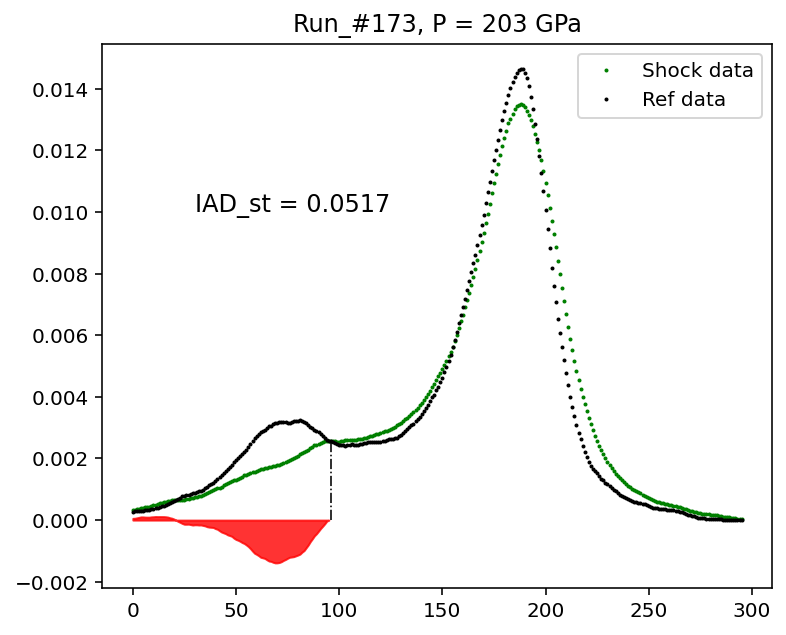

In [341]:
roi = '../xes/spectrum-173.h5'
laserOff_ol, laserOn_ol = read_xes(roi)
spect_ref = get_norm_spectrum(moving_average(remove_null(np.asarray(laserOff_ol)), n = n_smooth)[50:360])
spect = get_norm_spectrum(moving_average(remove_null(np.asarray(laserOn_ol)), n=n_smooth)[50:360])
i_max = spect.argmax()
i_ref_max = spect_ref.argmax()
i_dif =  i_ref_max - i_max
if i_dif < 0:
    spec_align = spect[-i_dif:]
    spec_r_align = spect_ref[:i_dif]
elif i_dif > 0:
    spec_align = spect[:-i_dif]
    spec_r_align = spect_ref[i_dif:]
else:
    spec_align = spect
    spec_r_align = spect_ref
    
transition_point = None
for j in range(60, 120):
    if spec_align[j] <= spec_r_align[j] and spec_align[j + 1] > spec_r_align[j + 1]:
        transition_point = j + 1
        break
if transition_point is None:
    transition_point = 100

iad_kb = np.sum(np.abs(spect-spect_ref))
iad_kb_st= np.sum(np.abs(spec_align[:transition_point]-spec_r_align[:transition_point]))
iad.append([int(run_num), iad_kb, iad_kb_st])
plt.figure(figsize=(6, 5))
plt.plot(spec_align, 'g.',ms = 2, label = 'Shock data')
plt.plot(spec_r_align, 'k.',ms = 2, label = 'Ref data')
plt.fill_between(np.arange(len(spec_align[:transition_point])), 0, spec_align[:transition_point]-spec_r_align[:transition_point], color = 'red', alpha = 0.8)
plt.vlines(transition_point, 0, spec_r_align[transition_point], linestyle='-.', lw =0.8, color = 'k')    
plt.text(30, 0.01, 'IAD_st = ' + str(round(iad_kb_st, 4)), fontsize = 12)
plt.title('Run_#173, P = 203 GPa')
plt.legend()
plt.savefig('./figs/Run173_example.png', bbox_inches = 'tight', dpi = 300)

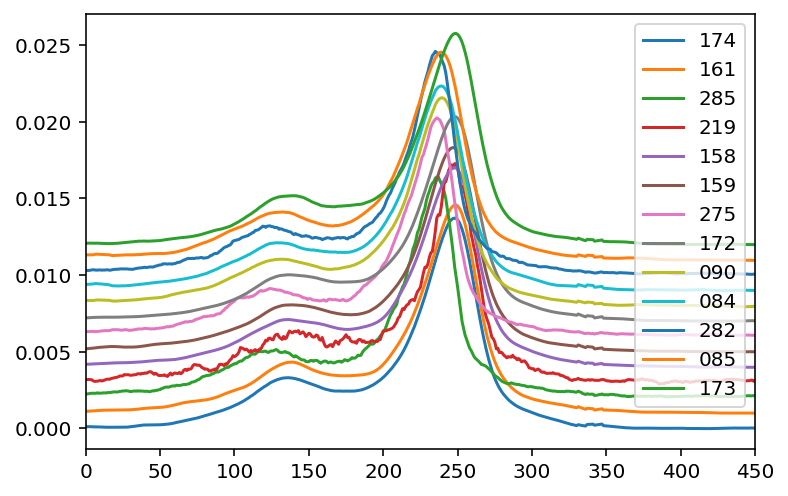

In [13]:
j = 0
for i in fl_roi:
    laserOff_ol, laserOn_ol = read_xes(i)
    plt.plot(moving_average(np.asarray(laserOff_ol), n = 11) + 0.001*j, label = i.split('-')[1].split('.h')[0])
    #plt.plot(moving_average(remove_null(np.asarray(laserOn_ol)), n= 11))
    plt.xlim(0, 450)
    plt.legend()
    j+=1
    #plt.title(i.split('-')[1].split('.h')[0])
    #plt.show()

In [26]:
# 164, 
ol_shots=[162, 286, 182, 171, \
          174, 288, 90, 283, 157, \
          161, 282, 284, 85, 159, \
          84, 275, 285, 158, 219, \
          172, 173]
# DS removed run 164 or 198 GPa because of the timing issue, XRD shows no pressure
ol_shock_p_VISAR=[np.nan, np.nan, np.nan, np.nan, #62,
                  86, np.nan, 70, np.nan, np.nan,
                  173, 178, np.nan, 141, 171,
                  120, 265, 254, 235, 203, 
                  256, 203]
"""
ol_shock_pmin_VISAR=[162, np.nan, np.nan, np.nan, #52,
                     29, np.nan, 26, np.nan, np.nan, 
                     116, np.nan, np.nan, 115, np.nan,
                    107, 245, 192, 213, 191, 
                     105, 190]
"""
ol_shock_pmin_VISAR=[162, np.nan, np.nan, np.nan, #52,
                     29, np.nan, 26, np.nan, np.nan, 
                     116, np.nan, np.nan, 115, np.nan,
                    107, 245, 192, 213, 191, 
                     105, 190]

err_p_VISAR=np.array(ol_shock_p_VISAR)-np.array(ol_shock_pmin_VISAR)
err_p_VISAR[13] = 20.
err_p_VISAR[-4] = 50.

p_run = [(run, p, p_err) for run, p, p_err in zip(ol_shots, ol_shock_p_VISAR, err_p_VISAR) if not np.isnan(p)]

# Save to CSV
#with open('data.csv', 'w', newline='') as file:
    #writer = csv.writer(file)
    #writer.writerow(['ol_shots', 'ol_shock_p_VISAR'])
    #writer.writerows(filtered_data)

In [303]:
hugoniot_run = [174, 161, 219, 172, 173]
for sublist in iad:
    # Iterate over each tuple in data
    for idx, tup in enumerate(p_run):
        # Check if the first item of the tuple matches the first item of the sublist
        if tup[0] == sublist[0]:
            if tup[0] in hugoniot_run:
                hgn = True
            else:
                hgn = False
            # Add the second and third items from the sublist to the corresponding tuple in data
            p_run[idx] = (tup[0], tup[1], tup[2], sublist[1], sublist[2], hgn)
if save_data: 
    headers = ['run_num', 'pressure', 'p_err', 'iad_kb', 'iad_kbst', 'hugoniot']
    csv_file = 'ol_iad_xwei.csv'
    df = pd.DataFrame(p_run, columns=headers)
    df.to_csv(csv_file, index=False)

In [322]:
r = [i[0] for i in p_run]
p = [i[1] for i in p_run]
p_err = [i[2] for i in p_run]
iad_kb = [i[3] for i in p_run]
iad_kbst = [i[4] for i in p_run]
hgn = [i[5] for i in p_run]

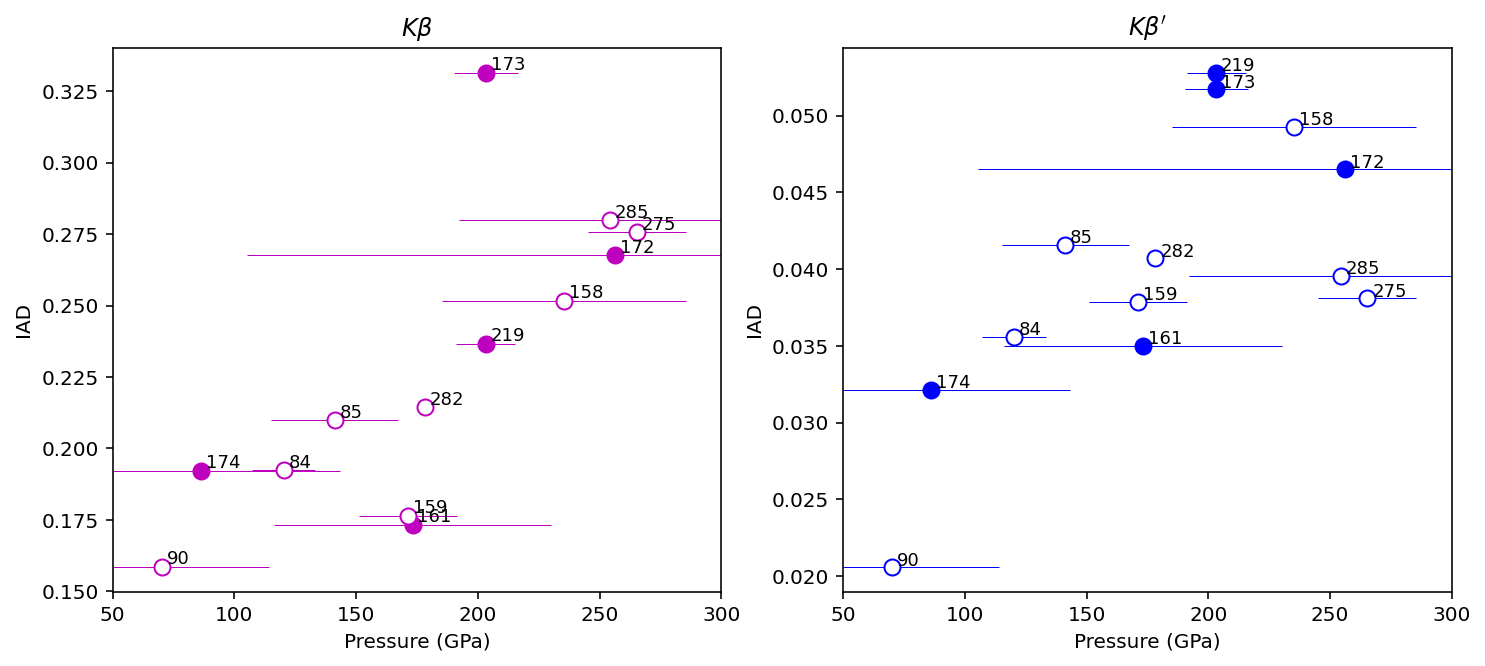

In [313]:
f, ax = plt.subplots(1, 2, figsize = (12, 5))
#ax[0].errorbar(p, iad_kb, xerr = p_err, ls = '', marker = 'o', mec = 'b', mfc = 'w', mew = 1, color = 'b', lw = 0.5, ms =8)
#ax[1].errorbar(p, iad_kbst, xerr = p_err, ls = '', marker = 'o', mec = 'b', mfc = 'w', mew = 1, color = 'b', lw = 0.5, ms =8)
facecolor = {True: 'm', False: 'w'}
facecolor_st= {True: 'b', False: 'w'}
ax[0].set_title('$K\u03B2$'); ax[1].set_title('$K\u03B2\'$') 
for prs, err, iads, run, h in zip(p, p_err, iad_kb, r, hgn):
    ax[0].errorbar(prs, iads, xerr = err, ls = '', marker = 'o', mec = 'm', 
                   mfc = facecolor[h], mew = 1, color = 'm', lw = 0.5, ms =8)
    ax[0].text(prs+2, iads+1e-3, run, fontsize = 9)
    
for prs, err, iads, run, h in zip(p, p_err, iad_kbst, r, hgn):
    ax[1].errorbar(prs, iads, xerr = err, ls = '', marker = 'o', mec = 'b', 
                   mfc = facecolor_st[h], mew = 1, color = 'b', lw = 0.5, ms =8)
    ax[1].text(prs+2, iads+1e-4, run, fontsize = 9)
for i in range(2):
    ax[i].set_xlabel('Pressure (GPa)')
    ax[i].set_ylabel('IAD')
    ax[i].set_xlim(50, 300)
if save_img:    
    plt.savefig('./figs/ol_iad_' + date + '.png', bbox_inches = 'tight', dpi = 200)

In [231]:
iad_dan = np.load('../xes_int/ol.npy')

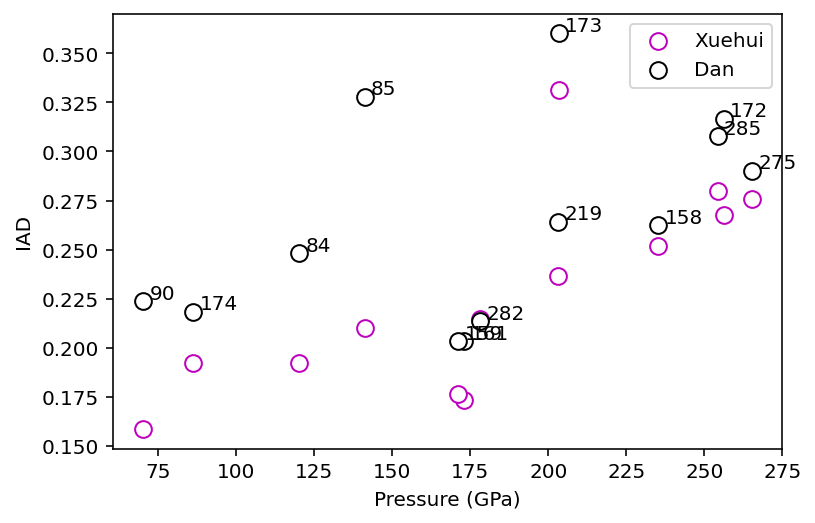

In [328]:
plt.scatter(p, iad_kb, c = 'w', ec = 'm', s = 70, label = 'Xuehui')
for i in range(len(iad_dan[0,:])):
    p_dan = int(iad_dan[0,:][i])
    if p_dan in r:
        idx = r.index(p_dan)
        plt.scatter(p[idx], iad_dan[2,:][i], c= 'w', ec = 'k',s= 70,  label = 'Dan' if r[idx] == 173 else None)
        plt.text(p[idx]+2, iad_dan[2,:][i]+0.001, r[idx])
plt.xlabel('Pressure (GPa)')
plt.ylabel('IAD')
plt.legend()

In [323]:
iad_kb 

[0.1922667337910901,
 0.1585710869837123,
 0.17325237396036647,
 0.21440825913296888,
 0.20988931239644099,
 0.1763440714513234,
 0.19231258755157252,
 0.2756309883543059,
 0.2797809325247519,
 0.25176050238527675,
 0.23654528037975486,
 0.2675372552653099,
 0.33146211495563677]

In [282]:
xes_85 = '../xes/spectrum-085.h5'

In [283]:
laserOff_ol, laserOn_ol = read_xes(xes_85)

In [284]:
np.sum(np.abs(np.asarray(laserOff_ol)-np.asarray(laserOn_ol)))

0.33054197

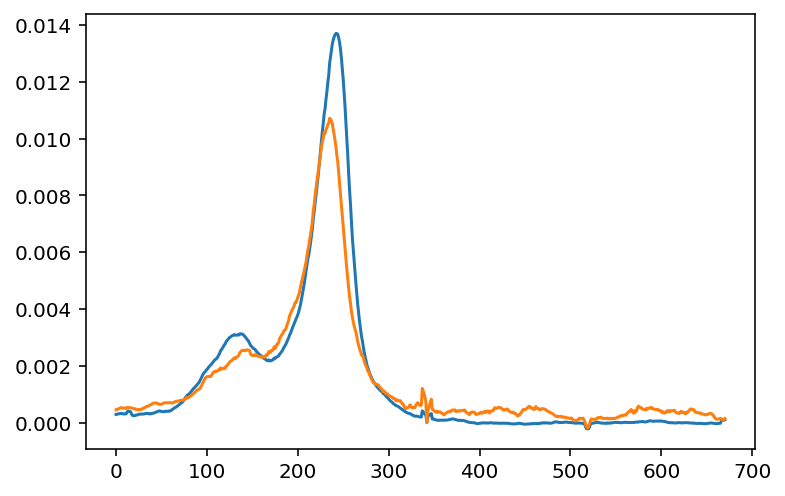

In [291]:
plt.plot(moving_average(np.asarray(laserOff_ol), n = n_smooth))
plt.plot(moving_average(np.asarray(laserOn_ol), n = n_smooth))

In [297]:
len(p_run)

13